Task:
1. Try to plot the Jet and MET pT response curve with increased statistics
 * each event should have multiple jets so 1000 events -> few thousand jets




In [3]:
import numpy as np
import pandas as pd
import time
import tqdm

import ROOT

import vector

In [6]:
import torch
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
device = "cuda"

In [8]:
# Datasets
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

# Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [9]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

In [10]:

import torch
from torch import nn
import torch.nn.functional as nnF

from torch import Tensor
from typing import Optional, Tuple

class QuantizeableMultiheadAttention(nn.MultiheadAttention):
    _FLOAT_MODULE = nn.MultiheadAttention

    r"""Quantizable implementation of the MultiheadAttention.

    Note::
        Please, refer to :class:`~torch.nn.MultiheadAttention` for more
        information

    Allows the model to jointly attend to information from different
    representation subspaces.
    See reference: Attention Is All You Need

    The original MHA module is not quantizable.
    This reimplements it by explicitly instantiating the linear layers.

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Note that if :attr:`kdim` and :attr:`vdim` are None, they will be set
    to :attr:`embed_dim` such that query, key, and value have the same
    number of features.

    Examples::

        >>> import torch.ao.nn.quantizable as nnqa
        >>> multihead_attn = nnqa.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)

    Note::
        Please, follow the quantization flow to convert the quantizable MHA.
    """
    __constants__ = ['batch_first']

    def __init__(self, embed_dim: int, num_heads: int,
                 dropout: float = 0., bias: bool = True,
                 add_bias_kv: bool = False, add_zero_attn: bool = False,
                 kdim: Optional[int] = None, vdim: Optional[int] = None, batch_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(embed_dim, num_heads, dropout,
                         bias, add_bias_kv,
                         add_zero_attn, kdim, vdim, batch_first,
                         **factory_kwargs)
        self.linear_Q = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_K = nn.Linear(self.kdim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_V = nn.Linear(self.vdim, self.embed_dim, bias=bias, **factory_kwargs)
        # for the type: ignore, see https://github.com/pytorch/pytorch/issues/58969
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)  # type: ignore[assignment]

        # Functionals
        # self.q_scaling_product = torch.ao.nn.quantized.FloatFunctional()
        # note: importing torch.ao.nn.quantized at top creates a circular import

        # Quant/Dequant
        self.quant_attn_output = torch.ao.quantization.QuantStub()
        self.quant_attn_output_weights = torch.ao.quantization.QuantStub()
        self.dequant_q = torch.ao.quantization.DeQuantStub()
        self.dequant_k = torch.ao.quantization.DeQuantStub()
        self.dequant_v = torch.ao.quantization.DeQuantStub()

    def _get_name(self):
        return 'QuantizableMultiheadAttention'

    @classmethod
    def from_float(cls, other):
        assert type(other) == cls._FLOAT_MODULE
        assert hasattr(other, 'qconfig'), "The float module must have 'qconfig'"
        # Setting the dropout to 0.0!
        observed = cls(other.embed_dim, other.num_heads, other.dropout,
                       (other.in_proj_bias is not None),
                       (other.bias_k is not None),
                       other.add_zero_attn, other.kdim, other.vdim,
                       other.batch_first)
        observed.bias_k = other.bias_k
        observed.bias_v = other.bias_v
        observed.qconfig = other.qconfig

        # Set the linear weights
        # for the type: ignores, see https://github.com/pytorch/pytorch/issues/58969
        observed.out_proj.weight = other.out_proj.weight  # type: ignore[has-type]
        observed.out_proj.bias = other.out_proj.bias  # type: ignore[has-type]
        if other._qkv_same_embed_dim:
            # Use separate params
            bias = other.in_proj_bias
            _start = 0
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_Q.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_Q.bias = bias

            bias = other.in_proj_bias
            _start = _end
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_K.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_K.bias = bias

            bias = other.in_proj_bias
            _start = _end
            weight = other.in_proj_weight[_start:, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:], bias.requires_grad)
            observed.linear_V.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_V.bias = bias
        else:
            observed.linear_Q.weight = nn.Parameter(other.q_proj_weight)
            observed.linear_K.weight = nn.Parameter(other.k_proj_weight)
            observed.linear_V.weight = nn.Parameter(other.v_proj_weight)
            if other.in_proj_bias is None:
                observed.linear_Q.bias = None  # type: ignore[assignment]
                observed.linear_K.bias = None  # type: ignore[assignment]
                observed.linear_V.bias = None  # type: ignore[assignment]
            else:
                observed.linear_Q.bias = nn.Parameter(other.in_proj_bias[0:other.embed_dim])
                observed.linear_K.bias = nn.Parameter(other.in_proj_bias[other.embed_dim:(other.embed_dim * 2)])
                observed.linear_V.bias = nn.Parameter(other.in_proj_bias[(other.embed_dim * 2):])
        observed.eval()
        # Explicit prepare
        observed = torch.ao.quantization.prepare(observed, inplace=True)
        return observed

    @torch.jit.unused
    def dequantize(self):
        r"""Utility to convert the quantized MHA back to float.

        The motivation for this is that it is not trivial to conver the weights
        from the format that is used in the quantized version back to the
        float.
        """
        fp = self._FLOAT_MODULE(self.embed_dim, self.num_heads, self.dropout,
                                (self.linear_Q._weight_bias()[1] is not None),
                                (self.bias_k is not None),
                                self.add_zero_attn, self.kdim, self.vdim, self.batch_first)
        assert fp._qkv_same_embed_dim == self._qkv_same_embed_dim
        if self.bias_k is not None:
            fp.bias_k = nn.Parameter(self.bias_k.dequantize())
        if self.bias_v is not None:
            fp.bias_v = nn.Parameter(self.bias_v.dequantize())

        # Set the linear weights
        # Note: Because the linear layers are quantized, mypy does not nkow how
        # to deal with them -- might need to ignore the typing checks.
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        w, b = self.out_proj._weight_bias()  # type: ignore[operator, has-type]
        fp.out_proj.weight = nn.Parameter(w.dequantize())
        if b is not None:
            fp.out_proj.bias = nn.Parameter(b)

        wQ, bQ = self.linear_Q._weight_bias()  # type: ignore[operator]
        wQ = wQ.dequantize()
        wK, bK = self.linear_K._weight_bias()  # type: ignore[operator]
        wK = wK.dequantize()
        wV, bV = self.linear_V._weight_bias()  # type: ignore[operator]
        wV = wV.dequantize()
        if fp._qkv_same_embed_dim:
            # Use separate params
            _start = 0
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wQ
            if fp.in_proj_bias is not None:
                assert all(bQ == 0)
                fp.in_proj_bias[_start:_end] = bQ

            _start = _end
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wK
            if fp.in_proj_bias is not None:
                assert all(bK == 0)
                fp.in_proj_bias[_start:_end] = bK

            _start = _end
            fp.in_proj_weight[_start:, :] = wV
            if fp.in_proj_bias is not None:
                assert all(bV == 0)
                fp.in_proj_bias[_start:] = bV
        else:
            fp.q_proj_weight = nn.Parameter(wQ)
            fp.k_proj_weight = nn.Parameter(wK)
            fp.v_proj_weight = nn.Parameter(wV)
            if fp.in_proj_bias is None:
                self.linear_Q.bias = None
                self.linear_K.bias = None
                self.linear_V.bias = None
            else:
                fp.in_proj_bias[0:fp.embed_dim] = bQ
                fp.in_proj_bias[fp.embed_dim:(fp.embed_dim * 2)] = bK
                fp.in_proj_bias[(fp.embed_dim * 2):] = bV

        return fp


    @classmethod
    def from_observed(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does float -> observed only
        # See nn.quantized.MultiheadAttention
        raise NotImplementedError("It looks like you are trying to prepare an "
                                  "MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    def forward(self,
                query: Tensor,
                key: Tensor,
                value: Tensor,
                key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True,
                attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True,
                is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Note::
        Please, refer to :func:`~torch.nn.MultiheadAttention.forward` for more
        information

    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - is_causal: If specified, applies a causal mask as attention mask. Mutually exclusive with providing attn_mask.
          Default: ``False``.
        - average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
          heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
          effect when ``need_weights=True.``. Default: True (i.e. average weights across heads)

        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - attn_output_weights: If ``average_attn_weights=True``, returns attention weights averaged
          across heads of shape :math:`(N, L, S)`, where N is the batch size, L is the target sequence length,
          S is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(N, num_heads, L, S)`.
        """
        return self._forward_impl(query, key, value, key_padding_mask,
                                  need_weights, attn_mask, average_attn_weights,
                                  is_causal)

    def _forward_impl(self,
                      query: Tensor,
                      key: Tensor,
                      value: Tensor,
                      key_padding_mask: Optional[Tensor] = None,
                      need_weights: bool = True,
                      attn_mask: Optional[Tensor] = None,
                      average_attn_weights: bool = True,
                      is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        # This version will not deal with the static key/value pairs.
        # Keeping it here for future changes.
        #
        # TODO: This method has some duplicate lines with the
        # `torch.nn.functional.multi_head_attention`. Will need to refactor.
        static_k = None
        static_v = None

        if attn_mask is not None and is_causal:
            raise AssertionError("Only allow causal mask or attn_mask")

        if is_causal:
            raise AssertionError("causal mask not supported by AO MHA module")

        if self.batch_first:
            query, key, value = (x.transpose(0, 1) for x in (query, key, value))

        tgt_len, bsz, embed_dim_to_check = query.size()
        assert self.embed_dim == embed_dim_to_check
        # allow MHA to have different sizes for the feature dimension
        assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

        head_dim = self.embed_dim // self.num_heads
        assert head_dim * self.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        scaling = float(head_dim) ** -0.5

        q = self.linear_Q(query)
        k = self.linear_K(key)
        v = self.linear_V(value)

        #JP fix here: disabled this
        # q = self.q_scaling_product.mul_scalar(q, scaling)

        if attn_mask is not None:
            if attn_mask.dtype == torch.uint8:
                warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
                attn_mask = attn_mask.to(torch.bool)
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f'Only float and bool types are supported for attn_mask, not {attn_mask.dtype}'

            if attn_mask.dim() == 2:
                attn_mask = attn_mask.unsqueeze(0)
                if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 2D attn_mask is not correct.')
            elif attn_mask.dim() == 3:
                if list(attn_mask.size()) != [bsz * self.num_heads, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 3D attn_mask is not correct.')
            else:
                raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")
            # attn_mask's dim is 3 now.

        # convert ByteTensor key_padding_mask to bool
        if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            key_padding_mask = key_padding_mask.to(torch.bool)
        if self.bias_k is not None and self.bias_v is not None:
            if static_k is None and static_v is None:

                # Explicitly assert that bias_k and bias_v are not None
                # in a way that TorchScript can understand.
                bias_k = self.bias_k
                assert bias_k is not None
                bias_v = self.bias_v
                assert bias_v is not None

                k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
                v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
                if attn_mask is not None:
                    attn_mask = nnF.pad(attn_mask, (0, 1))
                if key_padding_mask is not None:
                    key_padding_mask = nnF.pad(key_padding_mask, (0, 1))
            else:
                assert static_k is None, "bias cannot be added to static key."
                assert static_v is None, "bias cannot be added to static value."
        else:
            assert self.bias_k is None
            assert self.bias_v is None

        q = q.contiguous().view(tgt_len, bsz * self.num_heads, head_dim).transpose(0, 1)
        if k is not None:
            k = k.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)
        if v is not None:
            v = v.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)

        if static_k is not None:
            assert static_k.size(0) == bsz * self.num_heads
            assert static_k.size(2) == head_dim
            k = static_k

        if static_v is not None:
            assert static_v.size(0) == bsz * self.num_heads
            assert static_v.size(2) == head_dim
            v = static_v

        src_len = k.size(1)

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len

        if self.add_zero_attn:
            src_len += 1
            k_zeros = torch.zeros((k.size(0), 1) + k.size()[2:])
            if k.is_quantized:
                k_zeros = torch.quantize_per_tensor(k_zeros, k.q_scale(), k.q_zero_point(), k.dtype)
            k = torch.cat([k, k_zeros], dim=1)
            v_zeros = torch.zeros((v.size(0), 1) + k.size()[2:])
            if v.is_quantized:
                v_zeros = torch.quantize_per_tensor(v_zeros, v.q_scale(), v.q_zero_point(), v.dtype)
            v = torch.cat([v, v_zeros], dim=1)

            if attn_mask is not None:
                attn_mask = nnF.pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = nnF.pad(key_padding_mask, (0, 1))

        # Leaving the quantized zone here
        q = self.dequant_q(q)
        k = self.dequant_k(k)
        v = self.dequant_v(v)
        attn_output_weights = torch.bmm(q, k.transpose(1, 2))
        assert list(attn_output_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            if attn_mask.dtype == torch.bool:
                attn_output_weights.masked_fill_(attn_mask, float('-inf'))
            else:
                attn_output_weights += attn_mask

        if key_padding_mask is not None:
            attn_output_weights = attn_output_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_output_weights = attn_output_weights.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float('-inf'),
            )
            attn_output_weights = attn_output_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_output_weights = nnF.softmax(
            attn_output_weights, dim=-1)
        attn_output_weights = nnF.dropout(attn_output_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_output_weights, v)
        assert list(attn_output.size()) == [bsz * self.num_heads, tgt_len, head_dim]
        if self.batch_first:
            attn_output = attn_output.view(bsz, tgt_len, self.embed_dim)
        else:
            attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, self.embed_dim)

        # Reentering the quantized zone
        attn_output = self.quant_attn_output(attn_output)
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        attn_output = self.out_proj(attn_output)  # type: ignore[has-type]

        #JP fix: removed need_weights part from here, return attn_output instead of tuple
        return attn_output

class QuantizedMultiheadAttention(QuantizeableMultiheadAttention):
    _FLOAT_MODULE = torch.ao.nn.quantizable.MultiheadAttention

    def _get_name(self):
        return "QuantizedMultiheadAttention"

    @classmethod
    def from_float(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does observed -> quantized only
        raise NotImplementedError("It looks like you are trying to convert a "
                                  "non-observed MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    @classmethod
    def from_observed(cls, other):
        converted = torch.ao.quantization.convert(other, mapping=None,
                                                  inplace=False,
                                                  remove_qconfig=True,
                                                  convert_custom_config_dict=None)
        converted.__class__ = cls
        # Remove the parameters for the bias_k and bias_v to quantize them
        # TODO: This is a potential source of accuracy drop.
        #       quantized cat takes the scale and zp of the first
        #       element, which might lose the precision in the bias_k
        #       and the bias_v (which are cat'ed with k/v being first).
        if converted.bias_k is not None:
            bias_k = converted._parameters.pop('bias_k')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,
                                                      reduce_range=False)
            bias_k = torch.quantize_per_tensor(bias_k, sc, zp, torch.quint8)
            setattr(converted, 'bias_k', bias_k)  # noqa: B010

        if converted.bias_v is not None:
            bias_v = converted._parameters.pop('bias_v')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,  # type: ignore[possibly-undefined]
                                                      reduce_range=False)
            bias_v = torch.quantize_per_tensor(bias_v, sc, zp, torch.quint8)
            setattr(converted, 'bias_v', bias_v)  # noqa: B010

        del converted.in_proj_weight
        del converted.in_proj_bias

        return converted


In [11]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss
        
def mlpf_loss(y, ypred, mask):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    nelem = torch.sum(mask)
    npart = torch.sum(y["cls_id"] != 0)
    
    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all elements that were not padded
    loss["Classification"] = loss_classification.sum() / npart
    
    mom_normalizer = y["momentum"][y["cls_id"] != 0].std(axis=0)
    reg_losses = loss_regression[y["cls_id"] != 0]
    # average over all true particles
    loss["Regression"] = (reg_losses / mom_normalizer).sum() / npart

    px = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 3:4] * msk_true_particle
    py = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 2:3] * msk_true_particle
    pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

    px = y["momentum"][..., 0:1] * y["momentum"][..., 3:4] * msk_true_particle
    py = y["momentum"][..., 0:1] * y["momentum"][..., 2:3] * msk_true_particle
    true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)
    loss["MET"] = torch.nn.functional.huber_loss(pred_met, true_met).mean()

    loss["Total"] = loss["Classification"] + loss["Regression"]
    # loss["Total"] += 0.1*loss["MET"]
    return loss

In [12]:
class QuantizeFeaturesStub(torch.ao.quantization.QuantStub):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act(), nn.Linear(width, embedding_dim), self.act()
        )
        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
        # x = self.mul.mul(x, mask.unsqueeze(-1))
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum

In [13]:
import gc

In [14]:
max_events_train = 30000
max_events_eval = 30000
events_per_batch = 3000  # data points per batch
nepochs = 10
batch_size = 150 

In [10]:


model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES).to(device=device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

#  function to stream data (trying to avoid memory error)
def stream_data(dataset, batch_size, events_per_batch, chunk_size=1000):
    iterator = iter(dataset)
    while True:
        batch = []
        try:
            for _ in range(events_per_batch):
                batch.append(next(iterator))
        except StopIteration:
            break

        for i in range(0, len(batch), batch_size):
            yield batch[i:i + batch_size]

loss_vals_epochs = []
best_loss = float('inf')
patience = 3  
no_improvement = 0

for epoch in range(nepochs):
    loss_vals_steps = []
    
    data_stream = stream_data(ds_train, batch_size, events_per_batch)
    data_stream = tqdm.tqdm(data_stream, total=len(ds_train) // (batch_size * events_per_batch))
    
    for batch in data_stream:
        optimizer.zero_grad()

        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in batch]
        y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in batch]

        X_features_padded = pad_sequence(X_features, batch_first=True).to(device=device)
        y_targets_padded = pad_sequence(y_targets, batch_first=True).to(device=device)
        mask = X_features_padded[:, :, 0] != 0

        preds = model(X_features_padded, mask)
        preds_unpacked = unpack_predictions(preds)
        targets_unpacked = unpack_target(y_targets_padded)

        loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)
        loss["Total"].backward()
        optimizer.step()
        
        loss_vals_steps.append(loss["Total"].detach().cpu().item())

        del X_features, y_targets, X_features_padded, y_targets_padded, mask, preds, preds_unpacked, targets_unpacked, loss
        gc.collect()  #garbage collection

        data_stream.set_description(f"Epoch {epoch}, Loss: {np.mean(loss_vals_steps):.2f}")

    epoch_loss = np.mean(loss_vals_steps)
    loss_vals_epochs.append(epoch_loss)
    print(f"Epoch {epoch}, loss={epoch_loss:.2f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement >= patience:
        print("Early stopping: No improvement for", patience, "epochs")
        break
        
torch.save(model.state_dict(), 'trained_model.pth')


Epoch 0, Loss: 0.62: : 3192it [59:05,  1.11s/it]                                


Epoch 0, loss=0.62


Epoch 1, Loss: 0.42: : 3192it [1:07:46,  1.27s/it]                              


Epoch 1, loss=0.42


Epoch 2, Loss: 0.37: : 3192it [1:06:25,  1.25s/it]                              


Epoch 2, loss=0.37


Epoch 3, Loss: 0.35: : 3192it [1:04:38,  1.22s/it]                              


Epoch 3, loss=0.35


Epoch 4, Loss: 0.34: : 3192it [57:56,  1.09s/it]                                


Epoch 4, loss=0.34


Epoch 5, Loss: 0.33: : 3192it [57:54,  1.09s/it]                                


Epoch 5, loss=0.33


Epoch 6, Loss: 0.32: : 3192it [57:39,  1.08s/it]                                


Epoch 6, loss=0.32


Epoch 7, Loss: 0.31: : 3192it [57:30,  1.08s/it]                                


Epoch 7, loss=0.31


Epoch 8, Loss: 0.30: : 3192it [57:24,  1.08s/it]                                


Epoch 8, loss=0.30


Epoch 9, Loss: 0.30: : 3192it [57:26,  1.08s/it]                                


Epoch 9, loss=0.30


In [15]:
# Load the saved model
# Load the saved model
loaded_model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES).to(device=device)
loaded_model.load_state_dict(torch.load('trained_model.pth'))


<All keys matched successfully>

In [71]:
# print(batch_inds)
print(f'X_features',len(X_features))
print(f'y_features',len(y_targets))

NameError: name 'X_features' is not defined

In [11]:
data_stream = stream_data(ds_train, batch_size, events_per_batch)
batch = next(data_stream)  
X_features_length = [len(torch.tensor(elem["X"]).to(torch.float32)) for elem in batch]
print("Length of X_features:", X_features_length)


NameError: name 'stream_data' is not defined

In [16]:
#put the model back on CPU
model = loaded_model.to(device="cpu")

all_preds = []
all_targets = []

ds_elems = [ds_train[i] for i in range(max_events_train, max_events_train + max_events_eval)]

# Define batch size
batch_size = 32  
for i in range(0, len(ds_elems), batch_size):
    batch_elems = ds_elems[i:i + batch_size]
    # input features
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in batch_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    #  target labels
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in batch_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    #  mask for the batch
    mask = X_features_padded[:, :, 0] != 0
    #  model prediction, loss computation
    preds = model(X_features_padded, mask)
    preds = preds[0].detach(), preds[1].detach()
    # Update mask for the batch
    mask = X_features_padded[:, :, 0] != 0
    # Unpack predictions and targets for the batch
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    # append to a list 
    all_preds.append(preds_unpacked)
    all_targets.append(targets_unpacked)
    # Compute loss for the batch
    loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)

In [26]:
len(X_features)

16

In [27]:
import os

num_cores = os.cpu_count()
print("Number of CPU cores:", num_cores)


Number of CPU cores: 28


In [28]:
import psutil

# Get system memory information
memory_info = psutil.virtual_memory()

# Total physical memory
total_memory = memory_info.total / (1024 * 1024 * 1024)  # Convert bytes to gigabytes
print("Total Memory:", round(total_memory, 2), "GB")

# Available memory
available_memory = memory_info.available / (1024 * 1024 * 1024)  # Convert bytes to gigabytes
print("Available Memory:", round(available_memory, 2), "GB")

# Used memory
used_memory = memory_info.used / (1024 * 1024 * 1024)  # Convert bytes to gigabytes
print("Used Memory:", round(used_memory, 2), "GB")

# Percentage of memory usage
memory_percent = memory_info.percent
print("Memory Usage:", memory_percent, "%")


Total Memory: 160.69 GB
Available Memory: 143.01 GB
Used Memory: 15.01 GB
Memory Usage: 11.0 %


In [29]:
import os
import multiprocessing

# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

# Get the number of available CPU cores
available_cores = len(os.sched_getaffinity(0))
print("Number of available CPU cores:", available_cores)


Number of CPU cores: 28
Number of available CPU cores: 28


In [16]:
msk_true_particles = targets_unpacked["cls_id"]!=0
msk_pred_particles = preds_unpacked["cls_id"]!=0


pt_target = targets_unpacked["pt"][msk_true_particles].numpy()
pt_pred = preds_unpacked["pt"][msk_true_particles].numpy()

eta_target = targets_unpacked["eta"][msk_true_particles].numpy()
eta_pred = preds_unpacked["eta"][msk_true_particles].numpy()

sphi_target = targets_unpacked["sin_phi"][msk_true_particles].numpy()
sphi_pred = preds_unpacked["sin_phi"][msk_true_particles].numpy()

cphi_target = targets_unpacked["cos_phi"][msk_true_particles].numpy()
cphi_pred = preds_unpacked["cos_phi"][msk_true_particles].numpy()

energy_target = targets_unpacked["energy"][msk_true_particles].numpy()
energy_pred = preds_unpacked["energy"][msk_true_particles].numpy()

px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_true_particles
py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_true_particles
pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

In [17]:
len(targets_unpacked)
# targets_unpacked

9

In [18]:
len(preds_unpacked)

10

In [19]:
px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
pz = targets_unpacked["pt"] * np.sinh(targets_unpacked["eta"]) * msk_true_particles
# phi = np.arctan2(targets_unpacked["sin_phi"], targets_unpacked["cos_phi"]) * msk_true_particles

px_np = px.detach().cpu().numpy()
py_np = py.detach().cpu().numpy()
pz_np = pz.detach().cpu().numpy()
# phi_np = phi.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

true_mom = np.sqrt(np.sum(px_np, axis=1)**2 + np.sum(py_np, axis=1)**2 + np.sum(pz_np, axis=1)**2)

E = np.sqrt(px_np**2 + py_np**2 + pz_np**2)


In [20]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E.shape)
print("px Shape", px.shape)
print("py Shape", py.shape)
print("pz Shape", pz.shape)

E Shape (16, 234)
px Shape torch.Size([16, 234])
py Shape torch.Size([16, 234])
pz Shape torch.Size([16, 234])


In [21]:
import fastjet as fj
import numpy as np
import awkward

# Four momentum 
px_np = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py_np = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
pz_np = targets_unpacked["pt"] * np.sinh(targets_unpacked["eta"]) * msk_true_particles
E_np = np.sqrt(px_np**2 + py_np**2 + pz_np**2)


particles = []
for ip in range(E.shape[0]):
    for ix in range(E.shape[1]):
        px_value = float(px[ip, ix])
        py_value = float(py[ip, ix])
        pz_value = float(pz[ip, ix])
        E_value = float(E[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        particles.append(particle)

# print(particles)

In [22]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.08)
    jet_ptcut = 20
    
    cluster = fj.ClusterSequence(particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

chunks = [particles[i::num_threads] for i in range(num_threads)]

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

gen_jets = []
for future in futures:
    gen_jets.extend(future.result())


#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [23]:
for i, jet in enumerate(gen_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 0.0
Jet 2 : 0.01685715227271982 -1.7037463310659455 2.5152938215654848 0.04784475639462471
Jet 3 : 0.018829489773847664 -2.231184868570954 1.4913107164766937 0.08867081999778748
Jet 4 : 0.03099287304702732 -1.1108036477633083 3.3881593342743774 0.05216243490576744
Jet 5 : 0.0341145204121852 0.5755070071138421 0.890057701412335 0.03992168977856636
Jet 6 : 0.03714294610317665 -1.4618378745613343 0.8782223677243598 0.08442016690969467
Jet 7 : 0.043330297619299435 2.0682186858401552 6.087688416738415 0.17412561178207397
Jet 8 : 0.05486997911742172 -1.6383945336391674 1.8290250348484058 0.14653553068637848
Jet 9 : 0.05791084874138268 -1.5856144487758055 1.0106562105072923 0.14729949831962585
Jet 10 : 0.05867960199817778 -1.857655353966474 4.72417337085196 0.19260790944099426
Jet 11 : 0.06102171641708336 -0.9580629447873339 1.0930638183515125 0.0912359356880188
Jet 12 : 0.06942923772473732 1.8381249491447662 1.5678102969311545 0.22369608283042908
Jet 13 : 0.069606179

Jet 338 : 2.3354820564176717 1.3883329729963612 4.196055693124093 4.971837043762207
Jet 339 : 3.038075313463451 -0.6850361091960494 3.3896373147346814 3.780396670103073
Jet 340 : 2.4519199013660997 0.06347242586283657 2.1266388225101696 2.457600623369217
Jet 341 : 2.4312492590775947 0.5626655878247077 3.044121501805131 2.8263683319091797
Jet 342 : 2.4799337231912406 0.7707857278682687 2.2409067427633524 3.2538137435913086
Jet 343 : 2.49055911303368 -1.1433692076345323 5.465053240729749 4.303765773773193
Jet 344 : 2.4977712567981176 0.31690433224761133 5.2789167823429075 2.6242480278015137
Jet 345 : 2.589936633167217 -0.39702532160905496 5.2231437917797985 2.7967567443847656
Jet 346 : 3.409838258861895 -0.19934046568238728 3.4486825018282135 3.4795499444007874
Jet 347 : 2.661804694423908 -0.013865140722796496 5.506101370845078 2.6620731353759766
Jet 348 : 3.953925021913946 -0.7695561961448846 4.877320879947918 5.185726165771484
Jet 349 : 2.6748273995762655 -1.5638466758666505 3.83689124

Jet 630 : 0.5958794074859628 1.6950755777817559 1.3366484528191322 1.677592158317566
Jet 631 : 0.5983239291931841 -0.7565827308187687 4.564672412339578 0.7778955698013306
Jet 632 : 0.5983531175503682 -1.0012288452754832 0.013615613385376368 0.9241718649864197
Jet 633 : 0.603473848891471 0.13204215506609096 0.9532213599940363 0.6087422966957092
Jet 634 : 0.6068295452870417 -1.151913694853562 2.9645137861254653 1.0559664964675903
Jet 635 : 0.6092495387402111 -0.14167607611801397 2.182812407094757 0.6153742074966431
Jet 636 : 0.6103847792455147 1.7945267630137984 4.600147552733323 1.8869534730911255
Jet 637 : 0.6132788328275072 -1.7614743894723643 1.1284267937123502 1.837630271911621
Jet 638 : 0.6175568337793359 0.33841828828411125 5.875070245269531 0.653385579586029
Jet 639 : 0.6193387116531189 1.170071518811009 1.238531248166646 1.0939922034740448
Jet 640 : 0.626240341286307 -1.6565272720621145 2.593639150783916 1.7008308172225952
Jet 641 : 0.6301088966072504 -0.2151266751755839 1.70809

Jet 936 : 19.787152307266215 -1.0464263223073147 4.113303245195395 31.64606475830078
Jet 937 : 27.025015859306208 -1.049721614645447 2.522706267970671 43.344242095947266
Jet 938 : 26.6958412521487 -0.16024177259879258 2.3924313117489535 27.061194978654385
Jet 939 : 20.9004355671358 0.09513251725817301 3.905656927196509 20.99926620721817
Jet 940 : 22.072645353257176 -0.725321455262053 5.158106055583025 28.144394397735596
Jet 941 : 26.977307079193125 -0.7228236909821724 0.38202884738304704 34.349692940711975
Jet 942 : 23.321714168160963 0.9386479232409893 3.6942131849053417 34.372459411621094
Jet 943 : 25.61206177134723 -0.251984443379945 2.5466008062514947 26.433064460754395
Jet 944 : 35.273082256256146 -0.41194168001569303 2.257378290846283 38.32312712073326
Jet 945 : 32.15660078118613 -0.015640123906957838 4.346994672601687 32.16135501861572
Jet 946 : 40.125677131026094 -0.3869892153666121 5.617324953842743 43.183348298072815
Jet 947 : 37.62317103029886 0.15118498382547257 1.044365998

In [24]:
print("Number of Jets:", len(gen_jets))


gen_jet_pt = [jet.pt() for jet in gen_jets]

Number of Jets: 950


In [25]:
import ROOT
import numpy as np

bins = [10, 20, 30, 40, 60, 80, 100, 200]

x_vals = []
ratio_iqr_median = []

# Iterating over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filtering out jet pT values within each bin
    jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]
    print("Jet pT values in bin {}: {}".format(i+1, jet_values_in_bin))  # Debugging

Jet pT values in bin 1: [10.568565818251258, 13.127355157511566, 12.406079264900228, 10.338708937417959, 11.214937223847581, 10.274038384812865, 11.91544162303305, 12.543816265297275, 11.803264445112662, 18.582553427946184, 13.619279838790131, 13.558862631950822, 16.291363795177034, 15.69002178824146, 15.237741766847781, 14.886510336550979, 16.311368433043523, 16.73319606769277, 17.04137593633504, 17.84078606462316, 18.025129961181616, 14.874322192406455, 13.279398091663325, 13.432805949730945, 11.621040931825661, 13.241466197067016, 12.157741200984708, 12.960770327495597, 11.03543924428431, 15.279949301042484, 11.287883347270194, 11.511776831493558, 11.97930638689159, 12.025627947991515, 12.258517144894782, 12.37641943428418, 13.68502481969734, 14.09709741294674, 14.116329850527611, 14.453087626937256, 15.496866749831053, 19.771640465245856, 19.787152307266215]
Jet pT values in bin 2: [21.54060693039133, 28.40507312846964, 21.70145124251663, 23.496930192382887, 22.98092994512047, 26.0

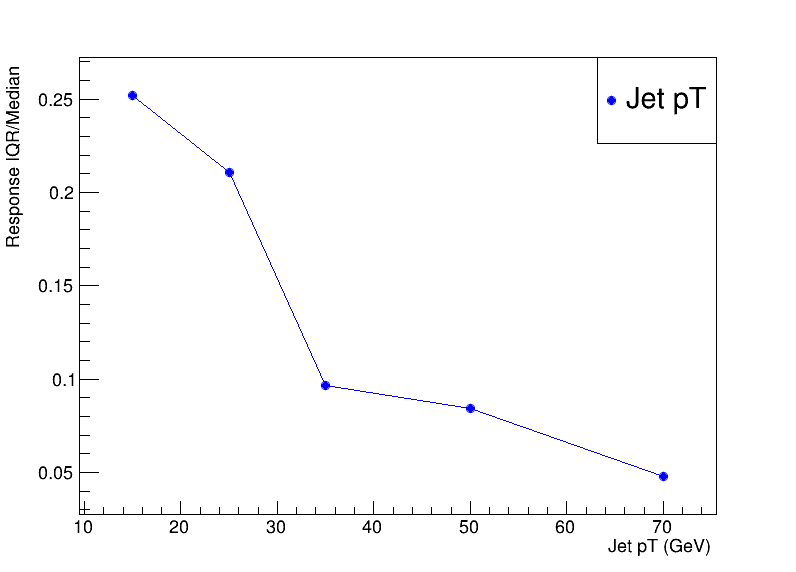

In [26]:
import ROOT
import numpy as np

# Define bins
# bins = [10, 20, 30, 40, 60, 80, 100, 200]
bins = [10, 20, 30, 40, 60, 80, 100]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter jet pT values within the bin
    jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any jet pT values in the bin
    if len(jet_values_in_bin) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue  # Skip calculation for this bin

    #  IQR and median for the jet pT values
    jet_iqr = np.percentile(jet_values_in_bin, 75) - np.percentile(jet_values_in_bin, 25)
    jet_median = np.median(jet_values_in_bin)
    ratio_iqr_median_ratio = jet_iqr / jet_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

#  We need to filter out NaN values,ROOT unable to print it
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))
# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet pT (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Jet pT", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


In [27]:
ratio_iqr_median

[0.2520650466228938,
 0.21064563869660383,
 0.09641749582421623,
 0.08443709560975672,
 0.04780784679887693,
 nan]

In [35]:
# For reconstructed particles


In [28]:
reco_px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_pred_particles
reco_py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_pred_particles
reco_pz = preds_unpacked["pt"] * np.sinh(preds_unpacked["eta"]) * msk_pred_particles
reco_phi = np.arctan2(preds_unpacked["sin_phi"], preds_unpacked["cos_phi"]) * msk_pred_particles

reco_px_np = reco_px.detach().cpu().numpy()
reco_py_np = reco_py.detach().cpu().numpy()
reco_pz_np = reco_pz.detach().cpu().numpy()
reco_phi_np = reco_phi.detach().cpu().numpy()

# print("reco_px_np", reco_px_np)
# print("reco_py_np", reco_py_np)
# print("reco_pz_np", reco_pz_np)
# print("reco_phi_np", reco_phi_np)

reco_pred_mom = np.sqrt(np.sum(reco_px_np, axis=1)**2 + np.sum(reco_py_np, axis=1)**2 + np.sum(reco_pz_np, axis=1)**2)

reco_E_np = np.sqrt(reco_px_np**2 + reco_py_np**2 + reco_pz_np**2)


In [29]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E_np.shape)
print("px Shape", reco_px_np.shape)
print("py Shape", reco_py_np.shape)
print("pz Shape", reco_pz_np.shape)


E Shape torch.Size([16, 234])
px Shape (16, 234)
py Shape (16, 234)
pz Shape (16, 234)


In [30]:

reco_particles = []   # TODO
for ip in range(E_np.shape[0]):
    for ix in range(E_np.shape[1]):
        px_value = float(reco_px_np[ip, ix])
        py_value = float(reco_py_np[ip, ix])
        pz_value = float(reco_pz_np[ip, ix])
        E_value = float(E_np[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        reco_particles.append(particle)


In [31]:
# reco_particles

In [32]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

# Function to perform jet clustering
def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.08)
#     jet_ptcut = 20
    
    cluster = fj.ClusterSequence(reco_particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

# Spliting particles list into chunks to process in parallel
chunks = [particles[i::num_threads] for i in range(num_threads)]

# jet clustering in parallel
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

reco_jets = []
for future in futures:
    reco_jets.extend(future.result())


In [34]:
for i, jet in enumerate(reco_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 285.0498991198838
Jet 2 : 0.0 100000.0 0.0 0.0
Jet 3 : 0.010538535373865029 -0.3308402685660366 4.242991100320957 0.35295766592025757
Jet 4 : 0.036643905559272244 2.4399849874153134 5.124209867984963 0.19705717265605927
Jet 5 : 0.05291501903935909 2.0989975907144793 6.0487096751689515 0.17412561178207397
Jet 6 : 0.06372871711963865 0.5824942817911968 0.8773007319640945 0.03992168977856636
Jet 7 : 0.07455798175137295 0.6250400767786606 0.00042762003678915357 0.2215946614742279
Jet 8 : 0.0760087797247576 1.1210888852478735 2.3073252427448 0.0
Jet 9 : 0.07852979078185986 -1.9564142383608625 4.677278120679455 0.19260790944099426
Jet 10 : 0.07877112868434123 -0.7955661597210925 3.6944749175531655 0.09268579632043839
Jet 11 : 0.08408917006098968 -1.36945117097291 0.9071491967920755 0.08442016690969467
Jet 12 : 0.09227494822327789 1.810938296147163 5.290292377303337 0.2458276003599167
Jet 13 : 0.09436335761380182 1.9032467669887998 1.5772831120055462 0.223696082830429

Jet 204 : 0.9058124118278809 -0.33054307779427883 0.5036188203949754 0.9203607439994812
Jet 205 : 0.6160419545686233 -0.22331952154184023 1.712064105400428 0.6447457671165466
Jet 206 : 0.617834715302781 0.224030036540182 6.031064736158774 0.5955650210380554
Jet 207 : 0.6218649321776315 1.7931082131062164 4.609844446045342 1.8869534730911255
Jet 208 : 0.6245891237743859 0.4190588763519952 4.195061871095499 0.5508260726928711
Jet 209 : 0.6269838862694939 0.1900038754228976 1.6027302880546286 0.6677400469779968
Jet 210 : 0.6290779728481009 1.0931984623514934 5.47112263989381 1.053753137588501
Jet 211 : 0.9125976681402251 -0.05439378399112905 1.3847515414741352 1.0048788189888
Jet 212 : 0.6331308375134035 -0.4692211800851429 1.8154371763027954 0.0
Jet 213 : 0.6353990212118155 -1.168118782549481 2.5199239782985754 1.1281617879867554
Jet 214 : 0.6412389073106952 0.19043571248308286 5.725278002318721 0.6593248844146729
Jet 215 : 0.6845660620800875 -0.7625152566778675 6.062520127967596 0.56770

Jet 419 : 1.8026619908397616 -0.2142414398381895 1.3061432907202077 1.8689782619476318
Jet 420 : 2.135354042414854 -0.1602611768098435 4.507597017001179 2.116531655192375
Jet 421 : 3.1286389217362247 -0.9331152055207885 5.738352241580093 3.7443883419036865
Jet 422 : 1.8519634828102816 0.9556006301533753 3.043882446747094 2.7459394931793213
Jet 423 : 2.654420423762758 0.54795595453975 5.339404276019858 3.0822949409484863
Jet 424 : 1.8678430532646169 -1.1679148561459234 2.0293935464822694 3.2870123386383057
Jet 425 : 1.8706354505092553 -0.31672869672086873 2.6670557089866076 1.8597739934921265
Jet 426 : 1.8721343188240849 0.07146583897204349 1.1560880620480636 1.5742912590503693
Jet 427 : 3.0224727995280265 0.2479154744260432 4.812767892099264 2.969353437423706
Jet 428 : 1.8790871796654167 0.5305615032105943 5.6110850501097795 2.1845499873161316
Jet 429 : 3.3619084194893865 0.8781105957904098 4.749680177912364 4.92824113368988
Jet 430 : 1.9025792275534603 -0.07400704219298142 2.389462619

Jet 761 : 0.15683753070211606 1.820760149325197 0.4316714009507998 0.49346187710762024
Jet 762 : 0.15833797246441547 1.048450598636008 1.591073715116452 0.12873141467571259
Jet 763 : 0.16090107860710412 1.136509588624121 6.241319484967952 0.16259807348251343
Jet 764 : 0.16460142587779458 1.9222911981069988 1.4180571377710613 0.9518731236457825
Jet 765 : 0.168014511939818 2.4172310354424136 1.1143161667218933 0.890738308429718
Jet 766 : 0.17046569955881644 -1.8981283201114196 1.457126962350121 0.6326783895492554
Jet 767 : 0.17538166239980252 1.9820684457692173 2.210340727818446 0.6485652327537537
Jet 768 : 0.17571736414534583 -1.6770093995684168 0.5513683547618032 0.2552036643028259
Jet 769 : 0.17672122339399401 2.144287653954229 2.0476789790098917 0.7338632345199585
Jet 770 : 0.18013915455971655 1.5997404513486255 5.706812278247172 0.4609612822532654
Jet 771 : 0.18216460902814768 1.0837382425339381 4.909743431575858 0.30101099610328674
Jet 772 : 0.18299307386125158 0.1516471789309078 1

Jet 1040 : 1.0395826969988555 -0.4246386233149718 0.8932646103800759 1.0383234024047852
Jet 1041 : 1.0456559774617191 -1.950183834614193 1.6211755588842731 3.7801318168640137
Jet 1042 : 1.0520507057256565 0.005404511848774753 3.734627057452165 0.3688104450702667
Jet 1043 : 1.0557701388421032 -1.0976042693572954 4.104454785906344 2.033583641052246
Jet 1044 : 1.0571403070860006 1.0323781633288482 2.5229029533579714 1.6993964910507202
Jet 1045 : 1.0734767025142742 0.6943170169609457 3.5758036766345693 1.2471801042556763
Jet 1046 : 1.0836259405935984 1.3611226084851884 1.1386114506728147 2.268627882003784
Jet 1047 : 1.085579597967254 1.9053079647567033 1.3721932290595138 2.95974063873291
Jet 1048 : 1.1243437257910158 0.497294462972476 3.960420592430843 1.3079420328140259
Jet 1049 : 1.094839136118354 -0.10289108951835635 0.10672197830947863 0.0
Jet 1050 : 1.096936907794462 0.1372512956732848 4.098575324658832 1.0201694965362549
Jet 1051 : 1.0970977138463451 -1.6755263927895812 4.81518782103

Jet 1298 : 4.357311357190653 -1.1727271930835563 5.792587474481599 8.000760078430176
Jet 1299 : 4.422318651710861 0.5306149176887449 5.07687846312049 5.076188087463379
Jet 1300 : 5.193949834958971 -0.11815858208325242 3.2972827276104706 5.184024125337601
Jet 1301 : 4.4513989660507995 -0.05178403645190346 4.770974347196981 4.419903010129929
Jet 1302 : 4.47412195555209 -0.29062700641608713 2.246028705760482 0.9375859946012497
Jet 1303 : 4.866982594169624 -0.016379054908584822 1.060636063499496 2.646260991692543
Jet 1304 : 4.611217640595121 -1.0118560137325008 4.824071462652655 7.298491954803467
Jet 1305 : 4.662500689554653 0.3300681557907506 5.563026754096899 6.211586773395538
Jet 1306 : 4.6645461108323465 -1.1903485843732655 5.663832616556906 8.370210647583008
Jet 1307 : 4.675637284172137 -0.28214329758274065 2.388586444593074 5.577007293701172
Jet 1308 : 4.681779071649739 0.14707728473211273 5.166779959589534 4.424570724368095
Jet 1309 : 4.736540767778304 -0.3595956285899891 6.21997309

In [35]:
print("Number of Jets:", len(reco_jets))


reco_jet_pt = [jet.pt() for jet in reco_jets]

Number of Jets: 1456


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


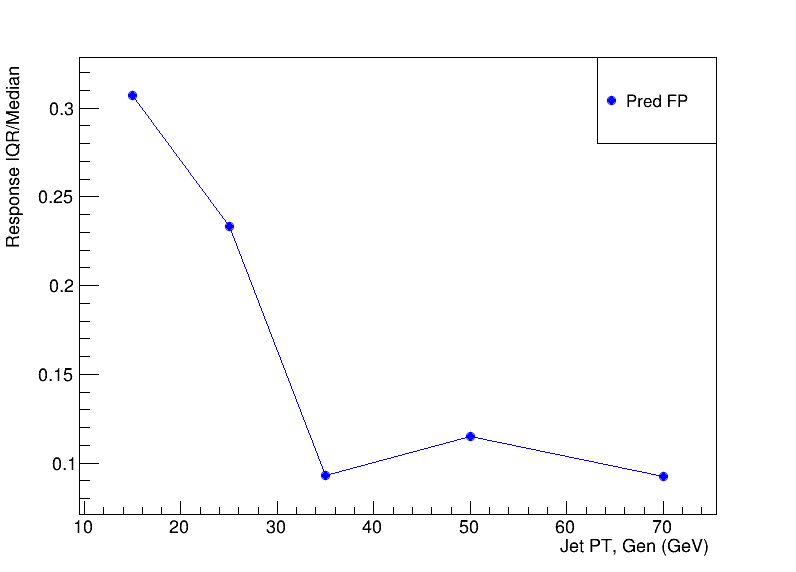

In [36]:
# bins = [10, 20, 30, 40, 60, 80, 100, 200]
bins = [10, 20, 30, 40, 60, 80, 100]


x_vals = []
ratio_iqr_median = []

for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0:
        ratio_iqr_median.append(np.nan)
        continue

    # IQR and median 
    ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet PT, Gen (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Get the X and Y axes
xaxis = gr_ratio.GetXaxis()
yaxis = gr_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)


# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Pred FP", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


No events in Bin 6.
No events in Bin 7.


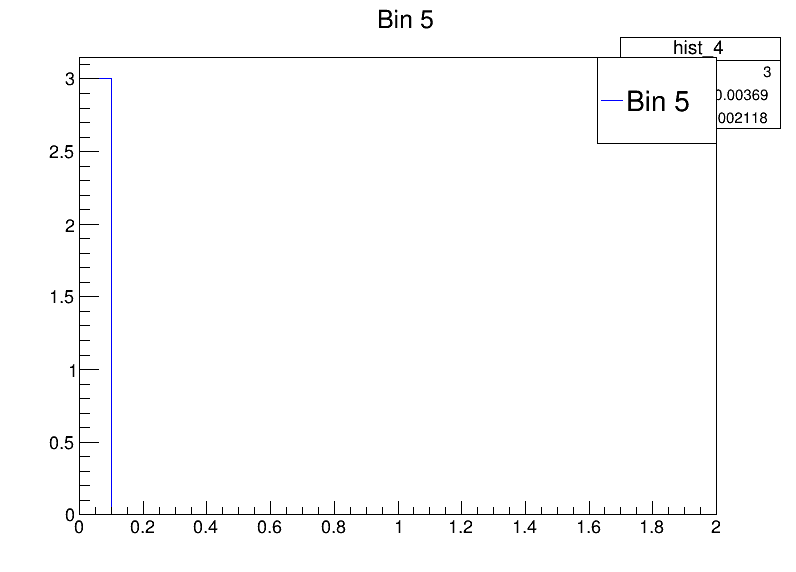

In [45]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Iterate over bins
for bin_index in range(len(bins) - 1):
    lim_low = bins[bin_index]
    lim_hi = bins[bin_index + 1]

    # Apply selection to gen_jet indices within the bin
    selected_indices_gen_jet = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices_gen_jet]

    # Check if there are any values in both selected gen_jet_pt and matched reco_jet_pt
    if len(selected_indices_gen_jet) == 0 or len(matched_reco_jet_values) == 0:
        print(f"No events in Bin {bin_index + 1}.")
        continue

    # Calculate IQR and median for matched reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(matched_reco_jet_values, selected_indices_gen_jet)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median

    # Create a canvas for the bin
    canvas = ROOT.TCanvas(f"canvas_{bin_index}", f"Response Distribution in Bin {bin_index + 1}", 800, 600)

    # Create histogram for the response distribution in the bin
    hist = ROOT.TH1F(f"hist_{bin_index}", f"  Bin {bin_index + 1}", 20, 0, 2)  # Adjust binning as needed
    for val in ratio_values_in_bin:
        hist.Fill(val)

    # Draw the histogram
    hist.SetLineColor(ROOT.kBlue)
    hist.Draw()

    # Add legend
    legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
    legend.AddEntry(hist, f"Bin {bin_index + 1}", "l")
    legend.Draw()

    # Show the canvas
    canvas.Draw()


In [37]:
# bins = [10, 20, 30, 40, 60, 80, 100, 200]
bins = [10, 20, 30, 40, 60, 80, 100]

for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    num_events_gen_jet = len(gen_jet_values_in_bin)
    num_events_reco_jet = len(reco_jet_values_in_bin)
    print(f"Bin {i+1}: Number of events (Gen Jet): {num_events_gen_jet}, Number of events (Reco Jet): {num_events_reco_jet}")


Bin 1: Number of events (Gen Jet): 43, Number of events (Reco Jet): 86
Bin 2: Number of events (Gen Jet): 15, Number of events (Reco Jet): 34
Bin 3: Number of events (Gen Jet): 7, Number of events (Reco Jet): 14
Bin 4: Number of events (Gen Jet): 7, Number of events (Reco Jet): 20
Bin 5: Number of events (Gen Jet): 3, Number of events (Reco Jet): 6
Bin 6: Number of events (Gen Jet): 0, Number of events (Reco Jet): 2


In [38]:
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]

    # Apply selection to gen_jet indices within the bin
    selected_indices_gen_jet = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices_gen_jet]

    # Calculate the number of events in the bin
    num_events_gen_jet = len(selected_indices_gen_jet)
    num_events_reco_jet = len(matched_reco_jet_values)

    print(f"Bin {i+1}: Number of events (Gen Jet): {num_events_gen_jet}, Number of events (Reco Jet): {num_events_reco_jet}")


Bin 1: Number of events (Gen Jet): 43, Number of events (Reco Jet): 43
Bin 2: Number of events (Gen Jet): 15, Number of events (Reco Jet): 15
Bin 3: Number of events (Gen Jet): 7, Number of events (Reco Jet): 7
Bin 4: Number of events (Gen Jet): 7, Number of events (Reco Jet): 7
Bin 5: Number of events (Gen Jet): 3, Number of events (Reco Jet): 3
Bin 6: Number of events (Gen Jet): 0, Number of events (Reco Jet): 0
Bin 7: Number of events (Gen Jet): 0, Number of events (Reco Jet): 0


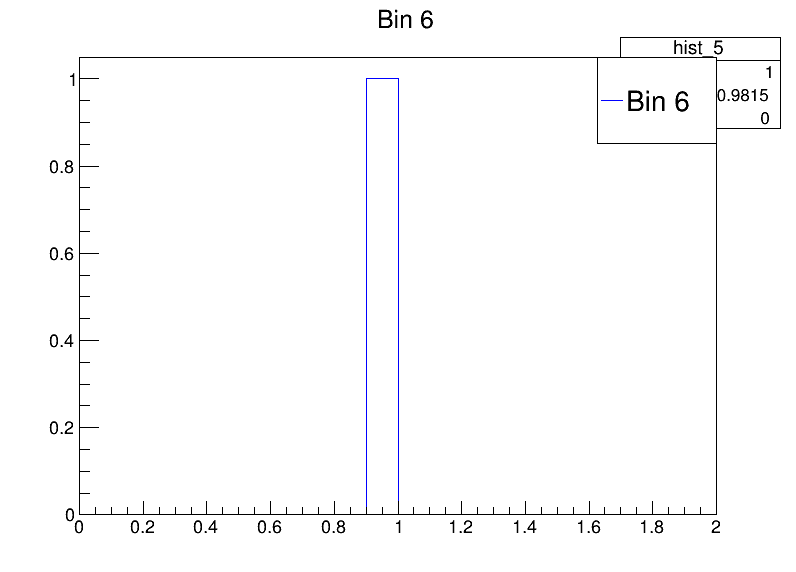

In [69]:
import ROOT
import numpy as np

# Define bins
# bins = [10, 20, 30, 40, 60, 80, 100, 200]
bins = [10, 20, 30, 40, 60, 80, 100]


# Define the bin index for the first bin (index 0)
bin_index = 5
# Get the bin limits
lim_low = bins[bin_index]
lim_hi = bins[bin_index + 1]
# Filter gen_jet pT values within the bin
gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

# Filter reco_jet pT values within the bin
reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

# Check if there are any values in both gen_jet_pt and reco_jet_pt
if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0:
    print("No events in the bin.")
else:
    # Calculate IQR and median for reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median
    # Create a canvas for the bin
    canvas = ROOT.TCanvas(f"canvas_{bin_index}", f"Response Distribution in Bin {bin_index + 1}", 800, 600)

    # Create histogram for the response distribution in the bin
    hist = ROOT.TH1F(f"hist_{bin_index}", f"  Bin {bin_index + 1}", 20, 0, 2) 
    for val in ratio_values_in_bin:
        hist.Fill(val)

    # Draw the histogram
    hist.SetLineColor(ROOT.kBlue)
    hist.Draw()

    # Add legend
    legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
    legend.AddEntry(hist, f"Bin {bin_index + 1}", "l")
    legend.Draw()

    # Show the canvas
    canvas.Draw()

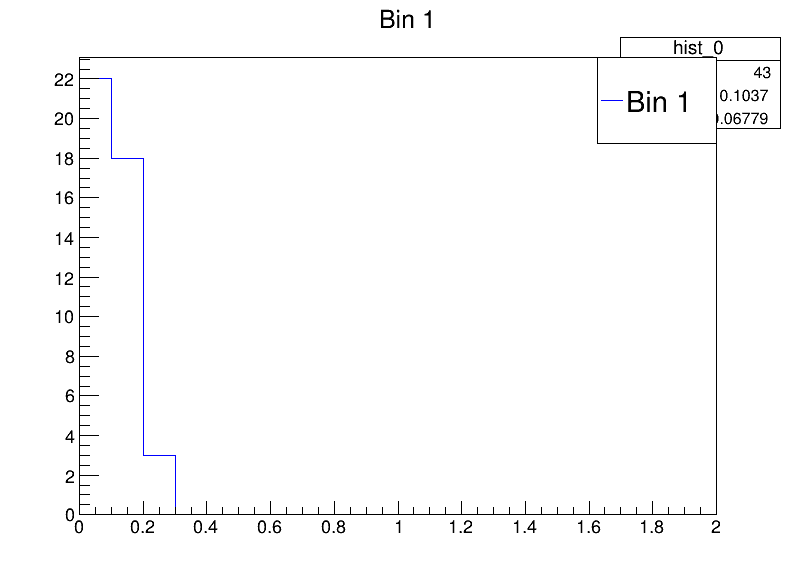

In [52]:
import ROOT
import numpy as np

# Define bins
# bins = [10, 20, 30, 40, 60, 80, 100, 200]
bins = [10, 20, 30, 40, 60, 80, 100]

# Define the bin index for the first bin (index 0)
bin_index = 0
# Get the bin limits
lim_low = bins[bin_index]
lim_hi = bins[bin_index + 1]

# Apply selection to gen_jet indices within the bin
selected_indices_gen_jet = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

# Match selected gen_jet indices to reco_jet values
matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices_gen_jet]

# Check if there are any values in both selected gen_jet_pt and matched reco_jet_pt
if len(selected_indices_gen_jet) == 0 or len(matched_reco_jet_values) == 0:
    print("No events in the bin.")
else:
    # Calculate IQR and median for matched reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(matched_reco_jet_values, gen_jet_values_in_bin)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median

    # Create a canvas for the bin
    canvas = ROOT.TCanvas(f"canvas_{bin_index}", f"Response Distribution in Bin {bin_index + 1}", 800, 600)

    # Create histogram for the response distribution in the bin
    hist = ROOT.TH1F(f"hist_{bin_index}", f"  Bin {bin_index + 1}", 20, 0, 2) 
    for val in ratio_values_in_bin:
        hist.Fill(val)

    # Draw the histogram
    hist.SetLineColor(ROOT.kBlue)
    hist.Draw()

    # Add legend
    legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
    legend.AddEntry(hist, f"Bin {bin_index + 1}", "l")
    legend.Draw()

    # Show the canvas
    canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


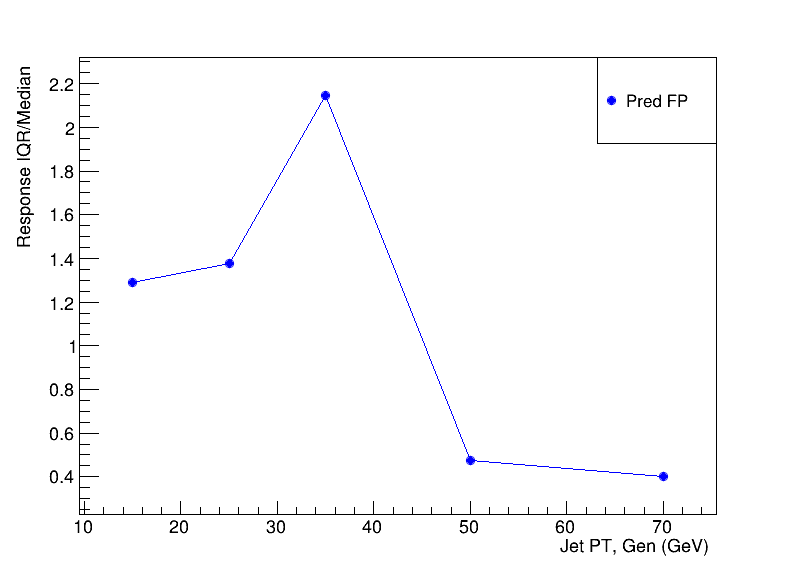

In [40]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Apply selection to gen_jet indices within the bin
    selected_indices = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices]

    # Check if there are any values in both selected gen_jet_pt and matched reco_jet_pt
    if len(selected_indices) == 0 or len(matched_reco_jet_values) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for matched reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen_jet_pt[idx] for reco, idx in zip(matched_reco_jet_values, selected_indices)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet PT, Gen (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Get the X and Y axes
xaxis = gr_ratio.GetXaxis()
yaxis = gr_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Pred FP", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


# Quantization INT8

In [41]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('onednn')
custom_module_config = {
        "float_to_observed_custom_module_class": {torch.nn.MultiheadAttention: QuantizeableMultiheadAttention},
        "observed_to_quantized_custom_module_class": {QuantizeableMultiheadAttention: QuantizedMultiheadAttention},
}

model_prepared = torch.ao.quantization.prepare(model, prepare_custom_config_dict=custom_module_config)

#calibrate on data
num_events_to_calibrate = 100
for ind in range(max_events_train,max_events_train+num_events_to_calibrate):
    _X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    _mask = _X[:, :, 0]!=0
    model_prepared(_X, _mask)

model_int8 = torch.ao.quantization.convert(model_prepared,convert_custom_config_dict=custom_module_config,)

/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [42]:
model_int8.quant

QuantizeFeaturesStub(
  (quants): ModuleList(
    (0): Quantize(scale=tensor([0.0078]), zero_point=tensor([0]), dtype=torch.quint8)
    (1): Quantize(scale=tensor([0.0402]), zero_point=tensor([136]), dtype=torch.quint8)
    (2): Quantize(scale=tensor([0.0384]), zero_point=tensor([124]), dtype=torch.quint8)
    (3-4): 2 x Quantize(scale=tensor([0.0078]), zero_point=tensor([127]), dtype=torch.quint8)
    (5): Quantize(scale=tensor([0.0317]), zero_point=tensor([104]), dtype=torch.quint8)
    (6): Quantize(scale=tensor([116.7670]), zero_point=tensor([26]), dtype=torch.quint8)
    (7): Quantize(scale=tensor([22.3554]), zero_point=tensor([130]), dtype=torch.quint8)
    (8): Quantize(scale=tensor([30.3783]), zero_point=tensor([130]), dtype=torch.quint8)
    (9): Quantize(scale=tensor([0.0121]), zero_point=tensor([0]), dtype=torch.quint8)
    (10): Quantize(scale=tensor([2.1723]), zero_point=tensor([0]), dtype=torch.quint8)
    (11): Quantize(scale=tensor([0.2938]), zero_point=tensor([26]), dt

In [43]:
mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
preds = model_int8(X_features_padded, mask_quantized)
preds = preds[0].detach(), preds[1].detach()
preds_unpacked_int8 = unpack_predictions(preds)

In [44]:
loss_int8 = mlpf_loss(targets_unpacked, preds_unpacked_int8, mask)

Text(0, 0.5, 'Final total loss')

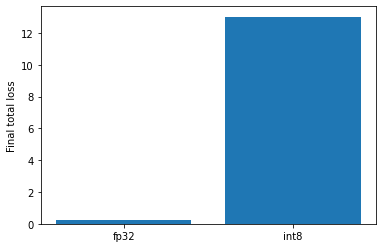

In [45]:
plt.bar(range(2), [loss["Total"].detach().numpy(), loss_int8["Total"].detach().numpy()])
plt.xticks(range(2), ["fp32", "int8"])
plt.ylabel("Final total loss")

In [46]:
pt_pred_int8 = preds_unpacked_int8["pt"][msk_true_particles].numpy()
eta_pred_int8 = preds_unpacked_int8["eta"][msk_true_particles].numpy()
sphi_pred_int8 = preds_unpacked_int8["sin_phi"][msk_true_particles].numpy()
cphi_pred_int8 = preds_unpacked_int8["cos_phi"][msk_true_particles].numpy()
energy_pred_int8 = preds_unpacked_int8["energy"][msk_true_particles].numpy()

px = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pred_met_int8 = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

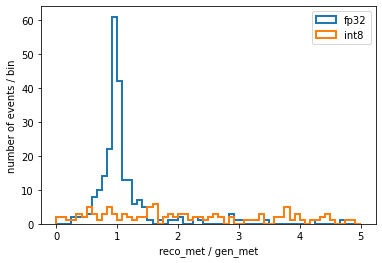

In [47]:
plt.hist(pred_met/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="fp32");
plt.hist(pred_met_int8/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="int8");
plt.xlabel("reco_met / gen_met")
plt.ylabel("number of events / bin")
plt.legend(loc="best")

In [48]:
# Defining the 3-momentum for the quantized particles.


In [49]:
px_int8 = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py_int8 = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pz_int8 = preds_unpacked_int8["pt"] * np.sinh(preds_unpacked_int8["eta"]) * msk_true_particles
phi_int8 = np.arctan2(preds_unpacked_int8["sin_phi"], preds_unpacked_int8["cos_phi"]) * msk_true_particles

px_np_int8 = px_int8.detach().cpu().numpy()
py_np_int8 = py_int8.detach().cpu().numpy()
pz_np_int8 = pz_int8.detach().cpu().numpy()
phi_np_int8 = phi_int8.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

quantized_mom = np.sqrt(np.sum(px_np_int8, axis=1)**2 + np.sum(py_np_int8, axis=1)**2 + np.sum(pz_np_int8, axis=1)**2)
int8_E_np = np.sqrt(px_np_int8**2 + py_np_int8**2 + pz_np_int8**2)


In [50]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("int8_E Shape", int8_E_np.shape)
print("px Shape", px_np_int8.shape)
print("py Shape", py_np_int8.shape)
print("pz Shape", pz_np_int8.shape)


int8_E Shape (16, 234)
px Shape (16, 234)
py Shape (16, 234)
pz Shape (16, 234)


In [51]:

INT8_Jets_particles = []   # TODO:Change this to reco_jets
for ip in range(int8_E_np.shape[0]):
    for ix in range(int8_E_np.shape[1]):
        px_value = float(px_np_int8[ip, ix])
        py_value = float(py_np_int8[ip, ix])
        pz_value = float(pz_np_int8[ip, ix])
        E_value = float(int8_E_np[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        INT8_Jets_particles.append(particle)


In [52]:
# INT8_Jets_particles

In [53]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.08)
#     jet_ptcut = 20
    
    cluster = fj.ClusterSequence(INT8_Jets_particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

chunks = [particles[i::num_threads] for i in range(num_threads)]

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

INT8_reco_jets = []
for future in futures:
    INT8_reco_jets.extend(future.result())


In [54]:
for i, jet in enumerate(INT8_reco_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 0.0
Jet 2 : 0.021257640674408867 -1.8494153684327395 3.292077744236326 0.0692300945520401
Jet 3 : 0.034104185554913395 1.0868520336868985 2.2335596075877717 0.05630946159362793
Jet 4 : 0.12848690606206 -4.077265268079755 2.707205120479333 3.790421485900879
Jet 5 : 0.1616113036154425 -2.981968999597325 4.560323700002844 1.5981186628341675
Jet 6 : 0.16772903951516 -2.665795650619546 3.8364113615837048 1.2117525339126587
Jet 7 : 0.24582060571986397 -0.0882310700444745 3.894062716198207 0.24677805602550507
Jet 8 : 0.2633220592441755 3.448340834828135 1.9441759124266405 4.1446852684021
Jet 9 : 0.2675076221300985 -0.9043401043998324 0.3544120534013725 0.38455694913864136
Jet 10 : 0.2702954175012689 0.27735371082471655 2.8625717031137348 0.28075850009918213
Jet 11 : 0.3010713029836208 -0.7606913254937144 3.1406421886342812 0.39246124029159546
Jet 12 : 0.3241026018267062 1.3158202302924706 1.842459271319499 0.6476051136851311
Jet 13 : 0.3312476879071581 -1.121868022969

Jet 296 : 5.061495880282001 -2.6113245818613677 4.116699781911343 34.647239685058594
Jet 297 : 5.075066874492639 -0.840077322214651 4.727920221270541 6.973708152770996
Jet 298 : 5.090375219658013 1.571878045531656 0.861675644472914 12.78533935546875
Jet 299 : 5.091795631349857 -2.188897802757804 5.298125825477229 23.008323669433594
Jet 300 : 5.110621565859628 0.7647756374534194 2.003241931086741 6.6794562339782715
Jet 301 : 5.124586537177023 2.1030122947942846 0.6842099229194026 21.300071716308594
Jet 302 : 5.160220351135824 -1.221340250368871 3.6929725680933827 9.512089490890503
Jet 303 : 5.196553025312768 0.10949441900633625 2.003474772300191 5.2277350425720215
Jet 304 : 5.197202869271705 -0.8586612310671144 0.8163637226225274 7.233799457550049
Jet 305 : 5.20266366062371 0.2733350207448789 1.7919916382102066 5.399392366409302
Jet 306 : 5.231339079967997 0.6632648542130307 1.54747833907475 6.425222992897034
Jet 307 : 9.810398255845195 -0.11050891672934125 1.825220475258774 9.880326032

Jet 626 : 63.08930298415213 -0.6303237908266459 5.024398913120866 76.05612373352051
Jet 627 : 63.71246857863866 -1.2182756413806746 3.925918800204984 117.13829803466797
Jet 628 : 64.2536275022449 -1.1066290488238715 4.757781627871349 107.79440462589264
Jet 629 : 67.9071665570603 -0.2076701862857396 4.168637577205848 69.37674713134766
Jet 630 : 72.55832758298158 -0.617408108182643 5.373928461115428 86.83260345458984
Jet 631 : 77.39079901967085 -1.1679848411196172 3.4926542077383735 136.4593048095703
Jet 632 : 81.00825070110888 0.47472145571034935 4.046064347358444 90.31021910905838
Jet 633 : 114.05829435238347 -0.7207986892350533 4.696035047462775 145.03936767578125
Jet 634 : 104.0730553905545 -1.5371116153256177 4.782391502748151 253.21725833415985
Jet 635 : 117.17957278814069 -0.6121328171157463 4.0673055682573995 139.86726713180542
Jet 636 : 111.40122137665749 -0.6834219284511559 3.8706324283970526 138.4502558708191
Jet 637 : 122.6326235139365 -1.0673717164809995 4.094236898358293 19

Jet 960 : 5.489130188773441 2.848386481546234 1.8233869240548137 47.52996063232422
Jet 961 : 7.910240753754117 0.21856169424979266 0.26170959278633366 8.103896856307983
Jet 962 : 5.533094135804698 2.526037829708065 2.198544499982887 34.813785552978516
Jet 963 : 8.36389647582618 -0.1838130211864828 1.4404354164749145 8.51100754737854
Jet 964 : 10.974006666887192 2.5396817609592355 1.0065445107999265 69.9854850769043
Jet 965 : 5.596134435435412 3.083082485709443 2.214672062453025 61.197628021240234
Jet 966 : 9.605608248664998 2.3233540275627624 0.9994894431992859 49.5081353187561
Jet 967 : 8.417561087526694 -0.2874250432118205 1.0719182618866752 8.77375864982605
Jet 968 : 5.646726180683203 3.071990803141444 2.3073196089879455 61.0726203918457
Jet 969 : 5.665892974922979 -0.4190335740974397 1.6479908652368314 6.171407222747803
Jet 970 : 5.675878956314764 -0.08436143532644227 0.5981718171855774 5.696087837219238
Jet 971 : 5.702113636496524 0.21049991773623614 0.8914842799888478 5.828911781

In [55]:
print("Number of Jets:", len(INT8_reco_jets))


INT8_jet_pt = [jet.pt() for jet in INT8_reco_jets]

Number of Jets: 1274


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


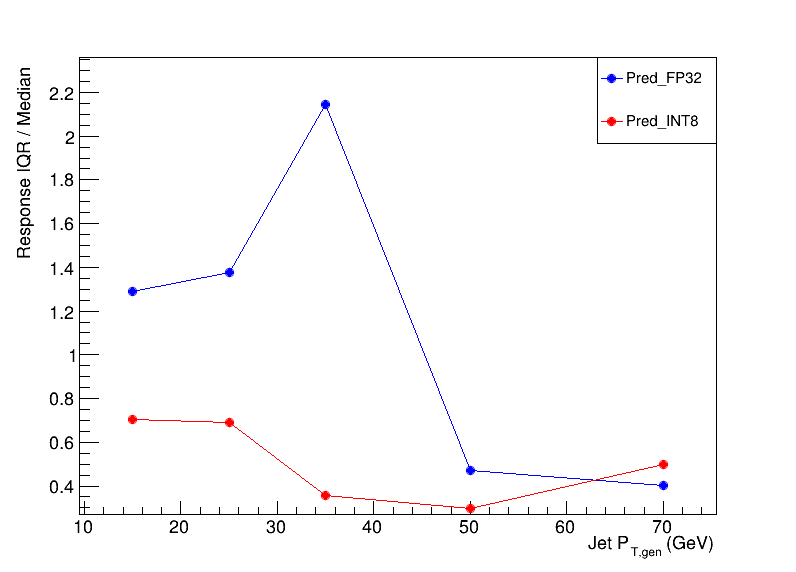

In [56]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100]

# Initialize lists to store values
x_vals = []
reco_ratio_iqr_median = []
int8_ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Apply selection to gen_jet indices within the bin
    selected_indices = [idx for idx, pt in enumerate(gen_jet_pt) if lim_low < pt <= lim_hi]

    # Match selected gen_jet indices to reco_jet values
    matched_reco_jet_values = [reco_jet_pt[idx] for idx in selected_indices]

    # Match selected gen_jet indices to INT8_jet values
    matched_int8_jet_values = [INT8_jet_pt[idx] for idx in selected_indices]

    # Check if there are any values in both selected gen_jet_pt and matched reco_jet_pt and INT8_jet_pt
    if len(selected_indices) == 0 or len(matched_reco_jet_values) == 0 or len(matched_int8_jet_values) == 0:
        # Append NaN values
        reco_ratio_iqr_median.append(np.nan)
        int8_ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for matched reco_jet_pt / gen_jet_pt values
    reco_ratio_values_in_bin = [reco / gen_jet_pt[idx] for reco, idx in zip(matched_reco_jet_values, selected_indices)]
    reco_ratio_iqr = np.percentile(reco_ratio_values_in_bin, 75) - np.percentile(reco_ratio_values_in_bin, 25)
    reco_ratio_median = np.median(reco_ratio_values_in_bin)
    reco_ratio_iqr_median_ratio = reco_ratio_iqr / reco_ratio_median
    reco_ratio_iqr_median.append(reco_ratio_iqr_median_ratio)

    # Calculate IQR and median for matched INT8_jet_pt / gen_jet_pt values
    int8_ratio_values_in_bin = [int8 / gen_jet_pt[idx] for int8, idx in zip(matched_int8_jet_values, selected_indices)]
    int8_ratio_iqr = np.percentile(int8_ratio_values_in_bin, 75) - np.percentile(int8_ratio_values_in_bin, 25)
    int8_ratio_median = np.median(int8_ratio_values_in_bin)
    int8_ratio_iqr_median_ratio = int8_ratio_iqr / int8_ratio_median
    int8_ratio_iqr_median.append(int8_ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered_reco = [x for x, y in zip(x_vals, reco_ratio_iqr_median) if not np.isnan(y)]
reco_ratio_iqr_median_filtered = [y for y in reco_ratio_iqr_median if not np.isnan(y)]

x_vals_filtered_int8 = [x for x, y in zip(x_vals, int8_ratio_iqr_median) if not np.isnan(y)]
int8_ratio_iqr_median_filtered = [y for y in int8_ratio_iqr_median if not np.isnan(y)]

# Create TGraphs with filtered values
gr_reco_ratio = ROOT.TGraph(len(x_vals_filtered_reco), np.array(x_vals_filtered_reco), np.array(reco_ratio_iqr_median_filtered))
gr_int8_ratio = ROOT.TGraph(len(x_vals_filtered_int8), np.array(x_vals_filtered_int8), np.array(int8_ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_reco_ratio.SetTitle("")
gr_int8_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the first graph (Reco_jet_pt/gen_jet_pt)
gr_reco_ratio.SetMarkerStyle(20)
gr_reco_ratio.SetMarkerColor(ROOT.kBlue)
gr_reco_ratio.SetLineColor(ROOT.kBlue)
gr_reco_ratio.GetXaxis().SetTitle("Jet P_{T,gen} (GeV)")
gr_reco_ratio.GetYaxis().SetTitle("Response IQR / Median")
gr_reco_ratio.Draw("APL")

# Draw the second graph (INT8_jet_pt/gen_jet_pt) on the same canvas
gr_int8_ratio.SetMarkerStyle(20)
gr_int8_ratio.SetMarkerColor(ROOT.kRed)
gr_int8_ratio.SetLineColor(ROOT.kRed)
gr_int8_ratio.Draw("PL same")

# Get the X and Y axes
xaxis = gr_reco_ratio.GetXaxis()
yaxis = gr_reco_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)

# Set y-axis range to show both plots
min_y = min(min(reco_ratio_iqr_median_filtered), min(int8_ratio_iqr_median_filtered))
max_y = max(max(reco_ratio_iqr_median_filtered), max(int8_ratio_iqr_median_filtered))
yaxis.SetRangeUser(min_y * 0.9, max_y * 1.1)

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_reco_ratio, "Pred_FP32", "lp")
legend.AddEntry(gr_int8_ratio, "Pred_INT8", "lp")
legend.Draw()

# Show the canvas
canvas.Draw()
